In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


In [3]:
dataset_path = "/Users/mihirtrivedi/Desktop/DL Project/kolmogorov_arnold_dataset.npz"
data = np.load(dataset_path)


In [4]:
X_train = data['X_train']
X_val = data['X_val']
X_test = data['X_test']
y_train = data['y_train']
y_val = data['y_val']
y_test = data['y_test']


In [5]:
# Hyperparameters
input_dim = X_train.shape[1]  # Number of input features (d)
num_outer = 2 * input_dim + 1  # Number of outer functions (2d + 1)
hidden_units_inner = 32  # Hidden units for inner networks
hidden_units_outer = 16  # Hidden units for outer networks
epochs = 50  # Training epochs
batch_size = 32  # Batch size


In [6]:
# Corrected definition for inner networks (ψ_qp)
def create_inner_network(hidden_units):
    inputs = layers.Input(shape=(1,))
    x = layers.Dense(hidden_units, activation="relu")(inputs)
    x = layers.Dense(hidden_units, activation="relu")(x)
    outputs = layers.Dense(1)(x)
    return models.Model(inputs, outputs, name="Inner_Network")


In [7]:
# Define the outer networks (Φ_q)
def create_outer_network(hidden_units):
    inputs = layers.Input(shape=(1,))
    x = layers.Dense(hidden_units, activation="relu")(inputs)
    x = layers.Dense(hidden_units, activation="relu")(x)
    outputs = layers.Dense(1)(x)
    return models.Model(inputs, outputs, name="Outer_Network")


In [8]:
# Assemble the full Kolmogorov-Arnold Network
class KolmogorovArnoldNetwork(tf.keras.Model):
    def __init__(self, input_dim, num_outer, hidden_units_inner, hidden_units_outer):
        super(KolmogorovArnoldNetwork, self).__init__()
        self.inner_networks = [
            create_inner_network(hidden_units_inner) for _ in range(input_dim)
        ]
        self.outer_networks = [
            create_outer_network(hidden_units_outer) for _ in range(num_outer)
        ]

    def call(self, inputs):
        # Compute inner sums (ψ_qp)
        inner_sums = []
        for i in range(len(self.outer_networks)):
            inner_sum = tf.add_n(
                [self.inner_networks[j](inputs[:, j:j+1]) for j in range(len(self.inner_networks))]
            )
            inner_sums.append(inner_sum)
        
        # Compute outer functions (Φ_q)
        outer_sums = tf.add_n(
            [self.outer_networks[k](inner_sums[k]) for k in range(len(self.outer_networks))]
        )
        return outer_sums


In [9]:
# Instantiate the KAN model
kan_model = KolmogorovArnoldNetwork(input_dim, num_outer, hidden_units_inner, hidden_units_outer)

# Compile the model
kan_model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss="mse", metrics=["mse"])

# Train the model
history = kan_model.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val),
    epochs=epochs, 
    batch_size=batch_size,
    verbose=1
)

# Evaluate the model
test_loss, test_mse = kan_model.evaluate(X_test, y_test, verbose=1)

# Predictions and Metrics
y_test_pred = kan_model.predict(X_test)
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print(f"Test MSE: {mse}")
print(f"Test R^2: {r2}")


Epoch 1/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 3630.2263 - mse: 3630.2263 - val_loss: 599.8388 - val_mse: 599.8388
Epoch 2/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 469.1576 - mse: 469.1576 - val_loss: 156.1815 - val_mse: 156.1815
Epoch 3/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 148.1017 - mse: 148.1017 - val_loss: 55.6382 - val_mse: 55.6382
Epoch 4/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 50.5925 - mse: 50.5925 - val_loss: 26.0824 - val_mse: 26.0824
Epoch 5/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22.0469 - mse: 22.0469 - val_loss: 22.8599 - val_mse: 22.8599
Epoch 6/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.9203 - mse: 14.9203 - val_loss: 9.4518 - val_mse: 9.4518
Epoch 7/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.4950 - mse: 9.4950 - val_loss: 6.9085 - val_mse: 6.9085
Epoch 8/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0272 - mse: 6.0272 - val_loss: 4.2515 - val_mse: 4.2515
Epoch 9/50
226/226 ━━━

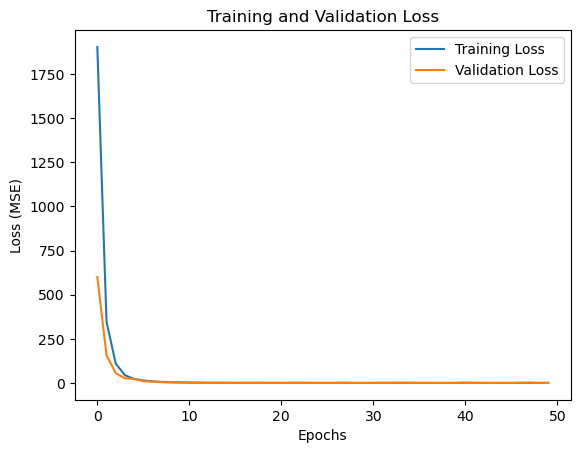

In [10]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [11]:
print(f"Test MSE: {test_mse}")


Test MSE: 0.2886562645435333


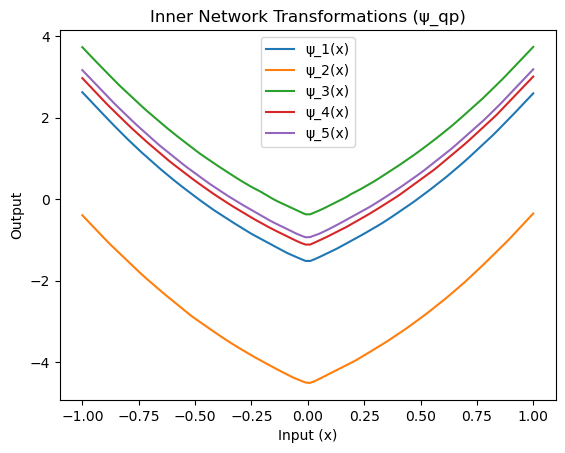

In [12]:
import numpy as np

# Visualize transformations for a sample input
for i, inner_net in enumerate(kan_model.inner_networks):
    sample_input = np.linspace(-1, 1, 100).reshape(-1, 1)
    output = inner_net(sample_input)
    plt.plot(sample_input, output, label=f'ψ_{i+1}(x)')

plt.xlabel('Input (x)')
plt.ylabel('Output')
plt.title('Inner Network Transformations (ψ_qp)')
plt.legend()
plt.show()


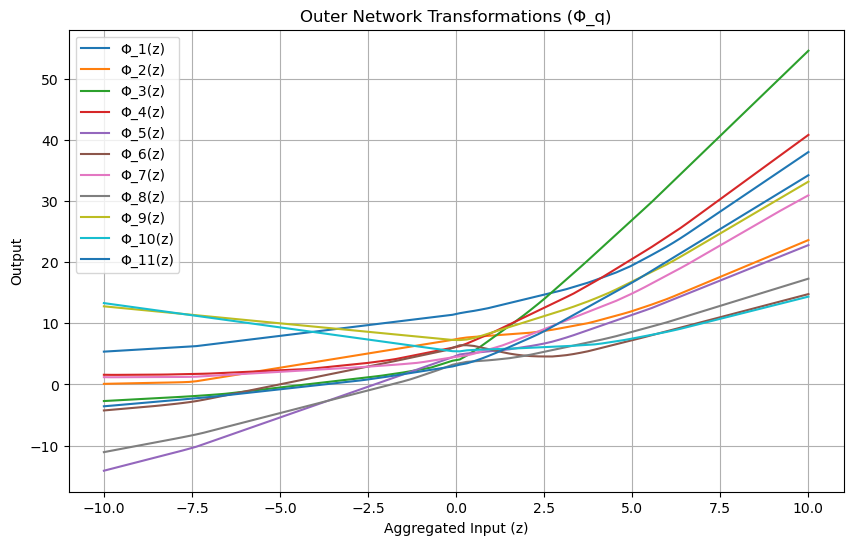

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Generate aggregated inputs (e.g., range of values for visualization)
aggregated_inputs = np.linspace(-10, 10, 100).reshape(-1, 1)

# Visualize transformations for each outer network
plt.figure(figsize=(10, 6))
for i, outer_net in enumerate(kan_model.outer_networks):
    output = outer_net(aggregated_inputs)
    plt.plot(aggregated_inputs, output, label=f'Φ_{i+1}(z)')

# Plot formatting
plt.xlabel('Aggregated Input (z)')
plt.ylabel('Output')
plt.title('Outer Network Transformations (Φ_q)')
plt.legend()
plt.grid(True)
plt.show()


In [14]:
def plot_loss(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.show()


In [15]:
def plot_predictions(model, X_test, y_test):
    y_pred = model.predict(X_test)
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2, label='Perfect Fit')
    plt.xlabel("True Output (y_test)")
    plt.ylabel("Predicted Output (y_pred)")
    plt.title("True vs Predicted Outputs")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Test MSE: {mse:.4f}, Test R^2: {r2:.4f}")



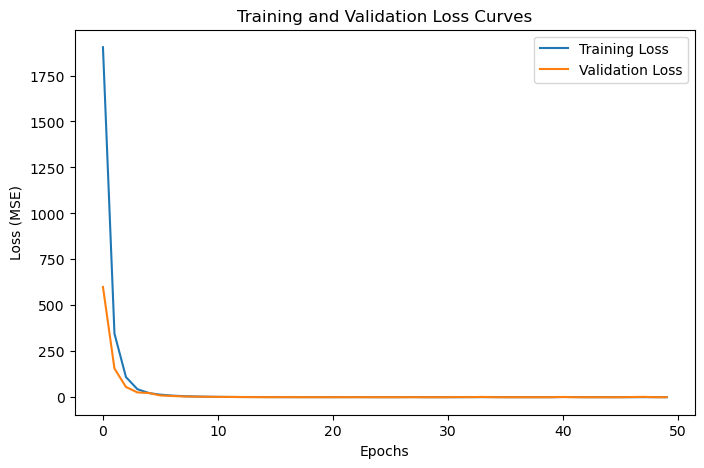

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step


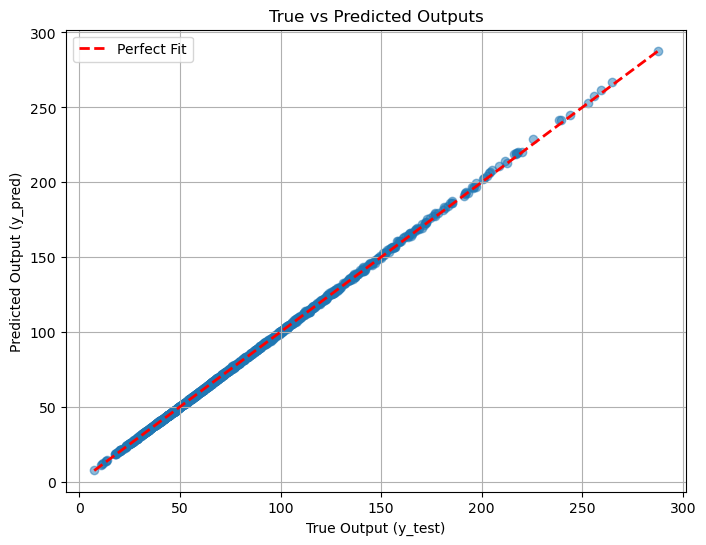

Test MSE: 0.2887, Test R^2: 0.9998


In [16]:
plot_loss(history)
plot_predictions(kan_model, X_test, y_test)

In [17]:
def plot_inner_networks(kan_model, input_range=(-1, 1), num_points=100):
    plt.figure(figsize=(10, 6))
    x_vals = np.linspace(input_range[0], input_range[1], num_points).reshape(-1, 1)
    
    for i, inner_net in enumerate(kan_model.inner_networks):
        y_vals = inner_net(x_vals)  # Output of inner network
        plt.plot(x_vals, y_vals, label=f'ψ_{i+1}(x_p)')
    
    plt.xlabel("Input Range (x_p)")
    plt.ylabel("Transformed Output (ψ_qp)")
    plt.title("Inner Network Transformations")
    plt.legend()
    plt.grid(True)
    plt.show()


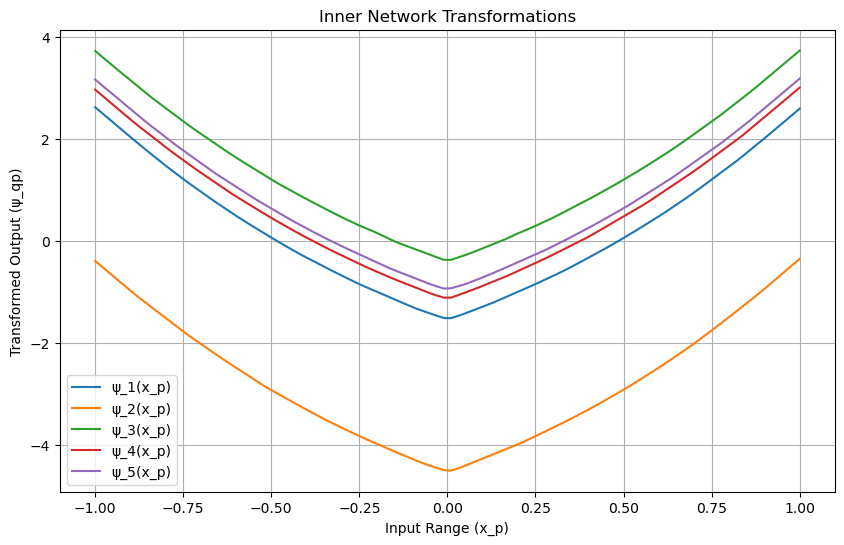

In [18]:
plot_inner_networks(kan_model)


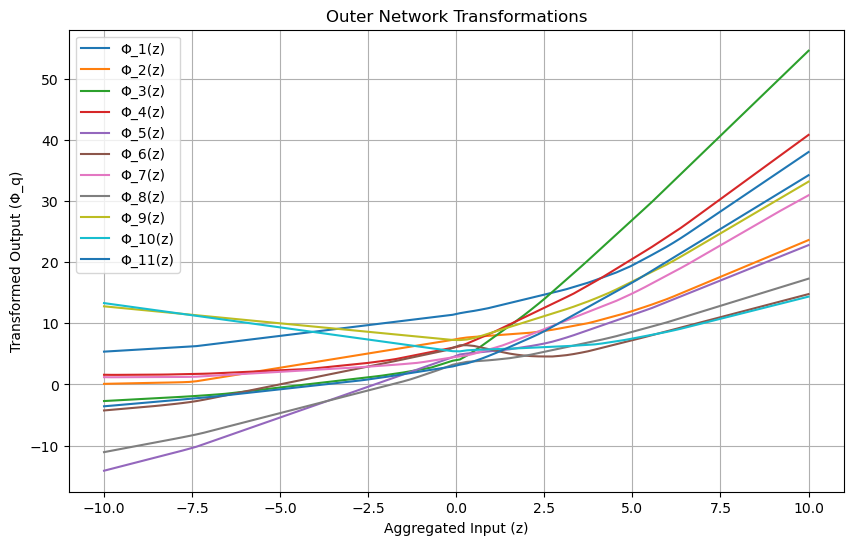

In [19]:
# Visualize transformations of the outer networks (Φ_q)
def plot_outer_networks(kan_model, input_range=(-10, 10), num_points=100):
    plt.figure(figsize=(10, 6))
    aggregated_inputs = np.linspace(input_range[0], input_range[1], num_points).reshape(-1, 1)
    
    for i, outer_net in enumerate(kan_model.outer_networks):
        y_vals = outer_net(aggregated_inputs)  # Output of outer network
        plt.plot(aggregated_inputs, y_vals, label=f'Φ_{i+1}(z)')
    
    plt.xlabel("Aggregated Input (z)")
    plt.ylabel("Transformed Output (Φ_q)")
    plt.title("Outer Network Transformations")
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function
plot_outer_networks(kan_model)


In [20]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error, r2_score

# Define the baseline MLP model
def build_mlp(input_dim, hidden_units=[64, 64], output_dim=1):
    model = Sequential()
    model.add(Dense(hidden_units[0], activation='relu', input_shape=(input_dim,)))
    for units in hidden_units[1:]:
        model.add(Dense(units, activation='relu'))
    model.add(Dense(output_dim))  # Output layer
    return model

# Hyperparameters for the MLP
mlp_hidden_units = [64, 64]
mlp_epochs = 50
mlp_batch_size = 32

# Build and compile the MLP model
mlp_model = build_mlp(input_dim=X_train.shape[1], hidden_units=mlp_hidden_units)
mlp_model.compile(optimizer='adam', loss='mse', metrics=['mse'])

# Train the MLP model
mlp_history = mlp_model.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val),
    epochs=mlp_epochs, 
    batch_size=mlp_batch_size,
    verbose=1
)

# Evaluate MLP on the test set
y_test_pred_mlp = mlp_model.predict(X_test)
mlp_test_mse = mean_squared_error(y_test, y_test_pred_mlp)
mlp_test_r2 = r2_score(y_test, y_test_pred_mlp)

# Print MLP performance
print(f"MLP Test MSE: {mlp_test_mse:.4f}, Test R^2: {mlp_test_r2:.4f}")


Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - loss: 6043.0566 - mse: 6043.0566 - val_loss: 1112.7736 - val_mse: 1112.7736
Epoch 2/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step - loss: 1108.6578 - mse: 1108.6578 - val_loss: 957.0545 - val_mse: 957.0545
Epoch 3/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step - loss: 954.9846 - mse: 954.9846 - val_loss: 839.5889 - val_mse: 839.5889
Epoch 4/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step - loss: 855.0229 - mse: 855.0229 - val_loss: 714.9404 - val_mse: 714.9404
Epoch 5/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step - loss: 716.3671 - mse: 716.3671 - val_loss: 599.5475 - val_mse: 599.5475
Epoch 6/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step - loss: 591.7791 - mse: 591.7791 - val_loss: 497.2987 - val_mse: 497.2987
Epoch 7/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step - loss: 524.7842 - mse: 524.7842 - val_loss: 406.5675 - val_mse: 406.5675
Epoch 8/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step - loss: 406.7608 - mse: 406.7608 - val_loss: 332.6234 -

In [21]:
print("Performance Comparison:")
print(f"KAN Test MSE: {test_mse:.4f}, Test R^2: {r2_score(y_test, kan_model.predict(X_test)):.4f}")
print(f"MLP Test MSE: {mlp_test_mse:.4f}, Test R^2: {mlp_test_r2:.4f}")


Performance Comparison:
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step
KAN Test MSE: 0.2887, Test R^2: 0.9998
MLP Test MSE: 14.8201, Test R^2: 0.9913


##Ablation Study##

In [26]:
class SimplifiedKAN(tf.keras.Model):
    def __init__(self, input_dim, reduced_num_outer, hidden_units_inner, hidden_units_outer):
        super(SimplifiedKAN, self).__init__()
        self.inner_networks = [
            create_inner_network(hidden_units_inner) for _ in range(input_dim)
        ]
        self.outer_networks = [
            create_outer_network(hidden_units_outer) for _ in range(reduced_num_outer)
        ]

    def call(self, inputs):
        # Compute inner sums (ψ_qp)
        inner_sums = []
        for i in range(len(self.outer_networks)):
            inner_sum = tf.add_n(
                [self.inner_networks[j](inputs[:, j:j+1]) for j in range(len(self.inner_networks))]
            )
            inner_sums.append(inner_sum)
        
        # Compute outer functions (Φ_q)
        outer_sums = tf.add_n(
            [self.outer_networks[k](inner_sums[k]) for k in range(len(self.outer_networks))]
        )
        return outer_sums
    # Instantiate a smaller KAN
reduced_num_outer = input_dim  # Reduced outer networks
simplified_kan = SimplifiedKAN(input_dim, reduced_num_outer, hidden_units_inner, hidden_units_outer)

# Compile and train the simplified KAN
simplified_kan.compile(optimizer='adam', loss='mse', metrics=['mse'])
# Compile and train the simplified KAN
simplified_history = simplified_kan.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),  # Ensure validation data is passed
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

# Evaluate the simplified KAN
simplified_test_mse = simplified_kan.evaluate(X_test, y_test, verbose=1)[1]
print(f"Simplified KAN Test MSE (Reduced Outer Networks): {simplified_test_mse:.4f}")


Epoch 1/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 4920.3779 - mse: 4920.3779 - val_loss: 774.1655 - val_mse: 774.1655
Epoch 2/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 642.6774 - mse: 642.6774 - val_loss: 290.3911 - val_mse: 290.3911
Epoch 3/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 246.7914 - mse: 246.7914 - val_loss: 135.9787 - val_mse: 135.9787
Epoch 4/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - loss: 138.0387 - mse: 138.0387 - val_loss: 108.4578 - val_mse: 108.4578
Epoch 5/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 107.3005 - mse: 107.3005 - val_loss: 69.5023 - val_mse: 69.5023
Epoch 6/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 67.2000 - mse: 67.2000 - val_loss: 40.2674 - val_mse: 40.2674
Epoch 7/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - loss: 38.0651 - mse: 38.0651 - val_loss: 25.1323 - val_mse: 25.1323
Epoch 8/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 25.2481 - mse: 25.2481 - val_loss: 15.9591 - val_mse: 15.

In [23]:
class LinearInnerKAN(tf.keras.Model):
    def __init__(self, input_dim, num_outer, hidden_units_outer):
        super(LinearInnerKAN, self).__init__()
        # Replace inner networks with linear layers
        self.inner_weights = [tf.Variable(tf.random.normal([1, 1])) for _ in range(input_dim)]
        self.inner_biases = [tf.Variable(tf.zeros([1])) for _ in range(input_dim)]
        self.outer_networks = [
            create_outer_network(hidden_units_outer) for _ in range(num_outer)
        ]

    def call(self, inputs):
        # Linear inner transformations
        inner_sums = []
        for i in range(len(self.outer_networks)):
            inner_sum = tf.add_n(
                [inputs[:, j:j+1] * self.inner_weights[j] + self.inner_biases[j]
                 for j in range(len(self.inner_weights))]
            )
            inner_sums.append(inner_sum)
        
        # Compute outer functions (Φ_q)
        outer_sums = tf.add_n(
            [self.outer_networks[k](inner_sums[k]) for k in range(len(self.outer_networks))]
        )
        return outer_sums

# Instantiate KAN with linear inner transformations
linear_inner_kan = LinearInnerKAN(input_dim, num_outer, hidden_units_outer)

# Compile and train
linear_inner_kan.compile(optimizer='adam', loss='mse', metrics=['mse'])
# Train Linear Inner KAN
linear_inner_history = linear_inner_kan.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

# Evaluate the Linear Inner KAN
linear_inner_test_mse = linear_inner_kan.evaluate(X_test, y_test, verbose=1)[1]
print(f"Linear Inner KAN Test MSE: {linear_inner_test_mse:.4f}")


Epoch 1/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 5325.7046 - mse: 5325.7046 - val_loss: 1600.9081 - val_mse: 1600.9081
Epoch 2/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - loss: 1557.5043 - mse: 1557.5043 - val_loss: 1409.8291 - val_mse: 1409.8291
Epoch 3/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - loss: 1433.3043 - mse: 1433.3043 - val_loss: 1379.1123 - val_mse: 1379.1123
Epoch 4/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - loss: 1383.9697 - mse: 1383.9697 - val_loss: 1374.2667 - val_mse: 1374.2667
Epoch 5/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step - loss: 1387.8219 - mse: 1387.8219 - val_loss: 1372.8427 - val_mse: 1372.8427
Epoch 6/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - loss: 1381.5079 - mse: 1381.5079 - val_loss: 1377.1677 - val_mse: 1377.1677
Epoch 7/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - loss: 1419.8138 - mse: 1419.8138 - val_loss: 1371.4230 - val_mse: 1371.4230
Epoch 8/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - loss: 1448.7437 - mse:

In [27]:
print("Ablation Study Results:")
print(f"Original KAN Test MSE: {test_mse:.4f}")
print(f"Simplified KAN (Reduced Outer) Test MSE: {simplified_test_mse:.4f}")
print(f"Linear Inner KAN Test MSE: {linear_inner_test_mse:.4f}")


Ablation Study Results:
Original KAN Test MSE: 0.2887
Simplified KAN (Reduced Outer) Test MSE: 0.0506
Linear Inner KAN Test MSE: 1556.5406


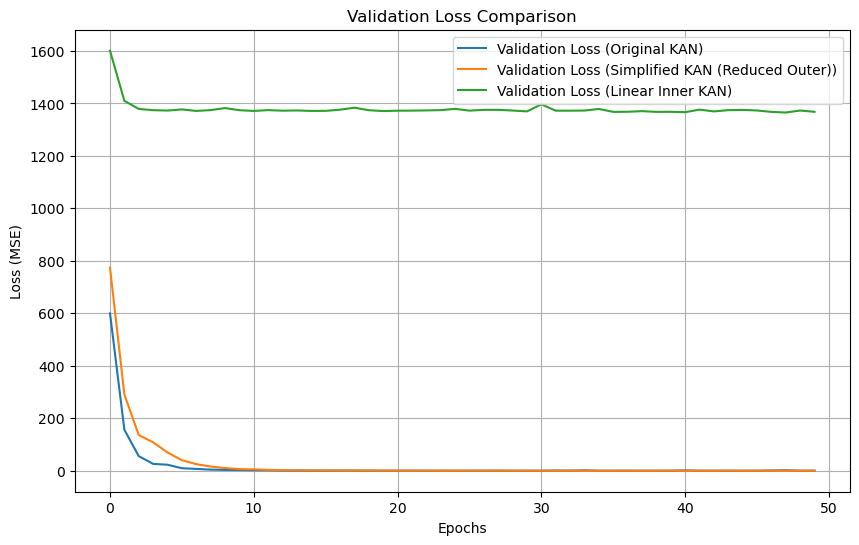

In [30]:
def plot_loss_comparison(histories, labels):
    plt.figure(figsize=(10, 6))
    for history, label in zip(histories, labels):
        plt.plot(history.history['val_loss'], label=f'Validation Loss ({label})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.title('Validation Loss Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()

# Compare Loss Curves
plot_loss_comparison(
    histories=[history, simplified_history, linear_inner_history],
    labels=["Original KAN", "Simplified KAN (Reduced Outer)", "Linear Inner KAN"]
)


In [33]:
print("Original KAN History Keys:", history.history.keys())
print("Simplified KAN History Keys:", simplified_history.history.keys())
print("Linear Inner KAN History Keys:", linear_inner_history.history.keys())


Original KAN History Keys: dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])
Simplified KAN History Keys: dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])
Linear Inner KAN History Keys: dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


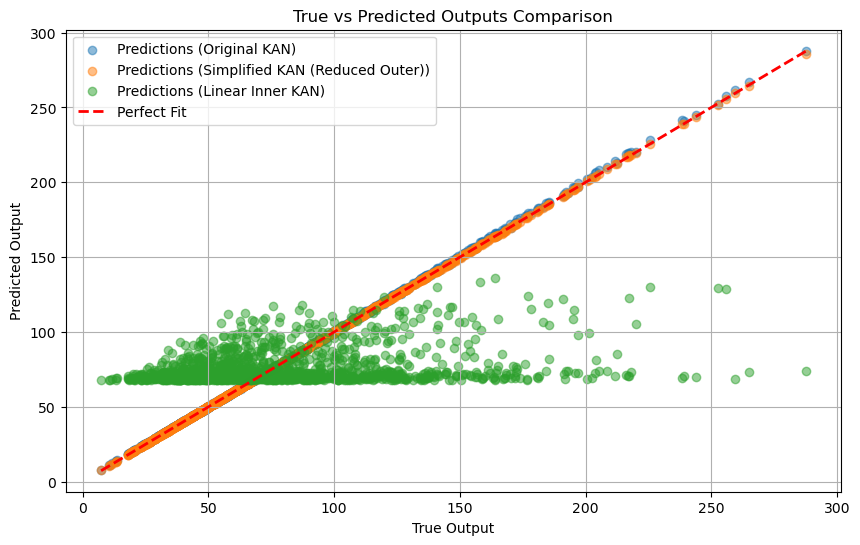

In [34]:
def plot_predictions_comparison(models, X_test, y_test, labels):
    plt.figure(figsize=(10, 6))
    for model, label in zip(models, labels):
        y_pred = model.predict(X_test)
        plt.scatter(y_test, y_pred, alpha=0.5, label=f'Predictions ({label})')
    
    # Perfect fit line
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2, label='Perfect Fit')
    plt.xlabel("True Output")
    plt.ylabel("Predicted Output")
    plt.title("True vs Predicted Outputs Comparison")
    plt.legend()
    plt.grid(True)
    plt.show()

# Compare Predictions
plot_predictions_comparison(
    models=[kan_model, simplified_kan, linear_inner_kan],
    X_test=X_test,
    y_test=y_test,
    labels=["Original KAN", "Simplified KAN (Reduced Outer)", "Linear Inner KAN"]
)
